In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from engine import ValueTensor
from visuals import draw_dot
from optim import SGD
from model import MLP

In [3]:
def mse(y, y_pred):
    return ((y - y_pred) ** 2).mean()

In [4]:

def train():
    # Dummy data
    x_data = np.random.randn(100, 1)
    y_data = 2 * x_data + 3 + 0.1 * np.random.randn(100, 1)  # Add noise

    # Wrap in ValueTensors
    X = ValueTensor(x_data)
    Y = ValueTensor(y_data)

    # Model
    model = MLP([1, 10, 1], activation='relu')
    optimizer = SGD(model.parameters(), lr=0.05)

    # Training loop
    for epoch in range(1000):
        # Forward
        preds = model(X)
        loss = mse(preds, Y)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss.data}")

    return loss

l = train()


Epoch 0: Loss = [[17.693]]
Epoch 100: Loss = [[0.036]]
Epoch 200: Loss = [[0.016]]
Epoch 300: Loss = [[0.012]]
Epoch 400: Loss = [[0.011]]
Epoch 500: Loss = [[0.01]]
Epoch 600: Loss = [[0.01]]
Epoch 700: Loss = [[0.01]]
Epoch 800: Loss = [[0.01]]
Epoch 900: Loss = [[0.01]]


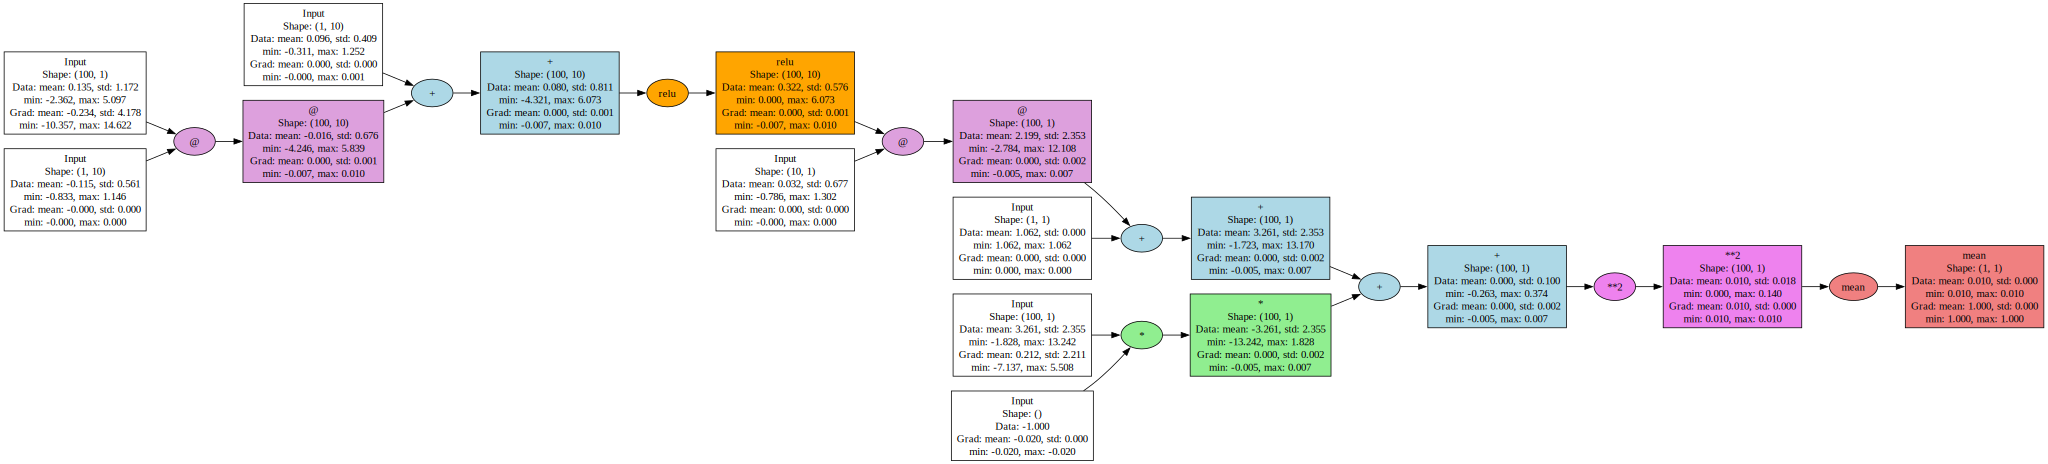

In [5]:
draw_dot(l)

In [6]:
from tests import run_all_tests

In [7]:
run_all_tests()

Addition test passed.
Multiplication test passed.
Matmul test passed.
Power test passed.
ReLU test passed.
Tanh test passed.
Sigmoid test passed.
Exp test passed.
Sum test passed.
Mean test passed.
Max test passed.
Reshape test passed.
Transpose test passed.
All tests passed successfully!


In [22]:
import torch
from torch import tensor as T
# from your_module import ValueTensor  # replace with actual import

def assert_allclose(actual, expected, tol=1e-5):
    assert np.allclose(actual, expected, atol=tol), f"Expected {expected}, got {actual}"

def test_binary_op(name, a_data, b_data, op_fn, torch_op_fn, backward_on='sum'):
    print(f"Testing: {name}")

    a = ValueTensor(a_data)
    b = ValueTensor(b_data)
    out = op_fn(a, b)

    # Backward
    if backward_on == 'sum':
        loss = ValueTensor(out.data.sum())
        loss._prev = {out}
        loss._op = "sum"
        def _backward():
            out.grad += np.ones_like(out.data)
        loss._backward = _backward
        loss.backward()
    else:
        out.backward()

    # Torch version
    ta = T(a_data, dtype=torch.float32, requires_grad=True)
    tb = T(b_data, dtype=torch.float32, requires_grad=True)
    tout = torch_op_fn(ta, tb)
    if backward_on == 'sum':
        tout.sum().backward()
    else:
        tout.backward()

    # Compare
    assert_allclose(out.data, tout.detach().numpy())
    assert_allclose(a.grad, ta.grad.numpy())
    assert_allclose(b.grad, tb.grad.numpy())

def test_unary_op(name, x_data, op_fn, torch_op_fn):
    print(f"Testing: {name}")
    x = ValueTensor(x_data)
    y = op_fn(x)
    loss = ValueTensor(y.data.sum())
    loss._prev = {y}
    loss._op = "sum"
    def _backward():
        y.grad += np.ones_like(y.data)
    loss._backward = _backward
    loss.backward()

    tx = T(x_data, dtype=torch.float32, requires_grad=True)
    ty = torch_op_fn(tx)
    ty.sum().backward()

    assert_allclose(y.data, ty.detach().numpy())
    assert_allclose(x.grad, tx.grad.numpy())

def run_all_tests():
    # Binary ops
    test_binary_op("add", [[1.0, 2.0]], [[3.0, 4.0]], lambda a, b: a + b, lambda a, b: a + b)
    test_binary_op("sub", [[1.0, 2.0]], [[3.0, 4.0]], lambda a, b: a - b, lambda a, b: a - b)
    test_binary_op("mul", [[1.0, 2.0]], [[3.0, 4.0]], lambda a, b: a * b, lambda a, b: a * b)
    test_binary_op("div", [[4.0, 9.0]], [[2.0, 3.0]], lambda a, b: a / b, lambda a, b: a / b)
    test_binary_op("matmul", [[1.0, 2.0]], [[3.0], [4.0]], lambda a, b: a @ b, lambda a, b: a @ b)

    # Unary ops
    test_unary_op("pow", [[1.0, 2.0]], lambda x: x ** 2, lambda x: x ** 2)
    test_unary_op("relu", [[-1.0, 2.0]], lambda x: x.relu(), lambda x: torch.nn.functional.relu(x))
    test_unary_op("tanh", [[-1.0, 2.0]], lambda x: x.tanh(), lambda x: torch.tanh(x))
    test_unary_op("sigmoid", [[-1.0, 2.0]], lambda x: x.sigmoid(), lambda x: torch.sigmoid(x))
    test_unary_op("exp", [[1.0, 2.0]], lambda x: x.exp(), lambda x: torch.exp(x))

# if __name__ == "__main__":
run_all_tests()


Testing: add
Testing: sub
Testing: mul
Testing: div
Testing: matmul
Testing: pow
Testing: relu
Testing: tanh
Testing: sigmoid
Testing: exp


In [ ]:
def test_tanh():
    x = ValueTensor([[0.0, 1.0]])
    y = x.tanh()  # y = tanh(x)
    y_sum = ValueTensor(y.data.sum())
    y_sum._prev = {y}
    y_sum._op = "sum"

    def _backward():
        y.grad += np.ones_like(y.data)
    y_sum._backward = _backward

    y_sum.backward()

    print("x.grad:")
    print(x.grad)
    print("Expected:")
    print(1 - np.tanh(x.data) ** 2)

test_tanh()


x.grad:
[[1.         0.41997434]]
Expected:
[[1.         0.41997434]]


In [ ]:
class Value:
  def __init__(self, data, _children = (), _op=""):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), "+")


    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), "*")

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other):
    return self * other ** -1

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __rsub__(self, other): # other - self
        return other + (-self)
  def __radd__(self, other): # other + self
        return self + other

  def __pow__(self, other):
    assert isinstance(other, (int, float))
    out = Value(self.data ** other, (self,), f'**{other}')

    def _backward():
      self.grad +=  other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward
    return out


  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/ (math.exp(2*x) + 1)

    def _backward():
      self.grad += (1 - t**2) * out.grad

    out = Value(t, (self,), "tanh")
    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self,), "exp")

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  def backward(self):
    visited = set()
    topo = []
    def give_topo(root):
      if root not in visited:
        visited.add(root)
        for child in root._prev:
          give_topo(child)
        topo.append(root)
    give_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [ ]:
a = Value(2.0)
b = Value(1.1)

c = a * b
d = c + b
# l = d.tanh()
# -------
e = (2 * d).exp()
l = (e - 1) / (e + 1)

In [ ]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    Visualizes the computational graph for tensor operations.

    format: e.g., 'png' or 'svg'
    rankdir: 'TB' (top to bottom) or 'LR' (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})

    for n in nodes:
        # Construct label with data summary, shape, and gradient summary.
        # You might want to truncate the data if it is large.
        shape_info = str(n.data.shape) if hasattr(n.data, 'shape') else "scalar"
        label = f"Shape: {shape_info} |" \
                f"Data: {n.data}|" \
                f"Grad: {n.grad}"
        dot.node(name=str(id(n)), label=label, shape='record')
        if n._op:
            # Add an operation node with a distinct style
            op_node = str(id(n)) + n._op
            dot.node(name=op_node, label=n._op, shape='oval')
            dot.edge(op_node, str(id(n)))

    for n1, n2 in edges:
        op_node = str(id(n2)) + n2._op if n2._op else str(id(n2))
        dot.edge(str(id(n1)), op_node)

    return dot

In [ ]:


def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot



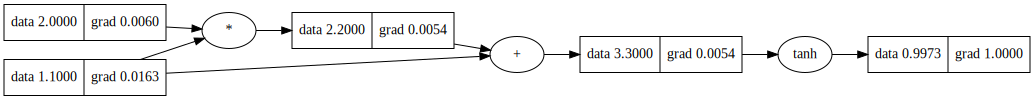

In [ ]:
draw_dot(l)

In [ ]:
l.backward()

In [ ]:
import random
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs

  def parameters(self):
    return [p for n in self.neurons for p in n.parameters()]

class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x[0] if len(x) ==1 else x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


n = MLP(3, [4,4,1])


In [ ]:
for k in range(20):
  xs = [
      [2.0, 3.0, -1.0],
      [3.0, -1.0, 0.5],
      [0.5, 1.0, 1.0],
      [1.0, 1.0, -1.0]
  ]
  ys = [1.0, -1.0, -1.0, 1.0]

  ypred = [n(x) for x in xs]

  loss= sum((yt - yp)**2 for yt, yp in zip(ys, ypred))
  loss.backward()

  for p in n.parameters():
    p.data = 0.0
    p.data += -0.1 * p.grad

  print(loss)

Value(data=6.378969781223489)
Value(data=3.9790243580844162)
Value(data=3.4094211960046055)
Value(data=2.5810407704755898)
Value(data=1.474950659443627)
Value(data=0.6877455133407604)
Value(data=0.35323479266430136)
Value(data=0.2196093902616751)
Value(data=0.15468373888818307)
Value(data=0.11761203522210088)
Value(data=0.09402897070844475)
Value(data=0.07786147685306917)
Value(data=0.06616035036214)
Value(data=0.0573382185913225)
Value(data=0.0504712870265803)
Value(data=0.0449881368952354)
Value(data=0.04051763469638521)
Value(data=0.036808918807348184)
Value(data=0.03368669839342137)
Value(data=0.03102500325482748)


In [ ]:
ypred

[Value(data=0.9364572118731856),
 Value(data=-0.9394087795714376),
 Value(data=-0.8914899583870376),
 Value(data=0.8925681974086407)]

Value(data=4.339588763632975)

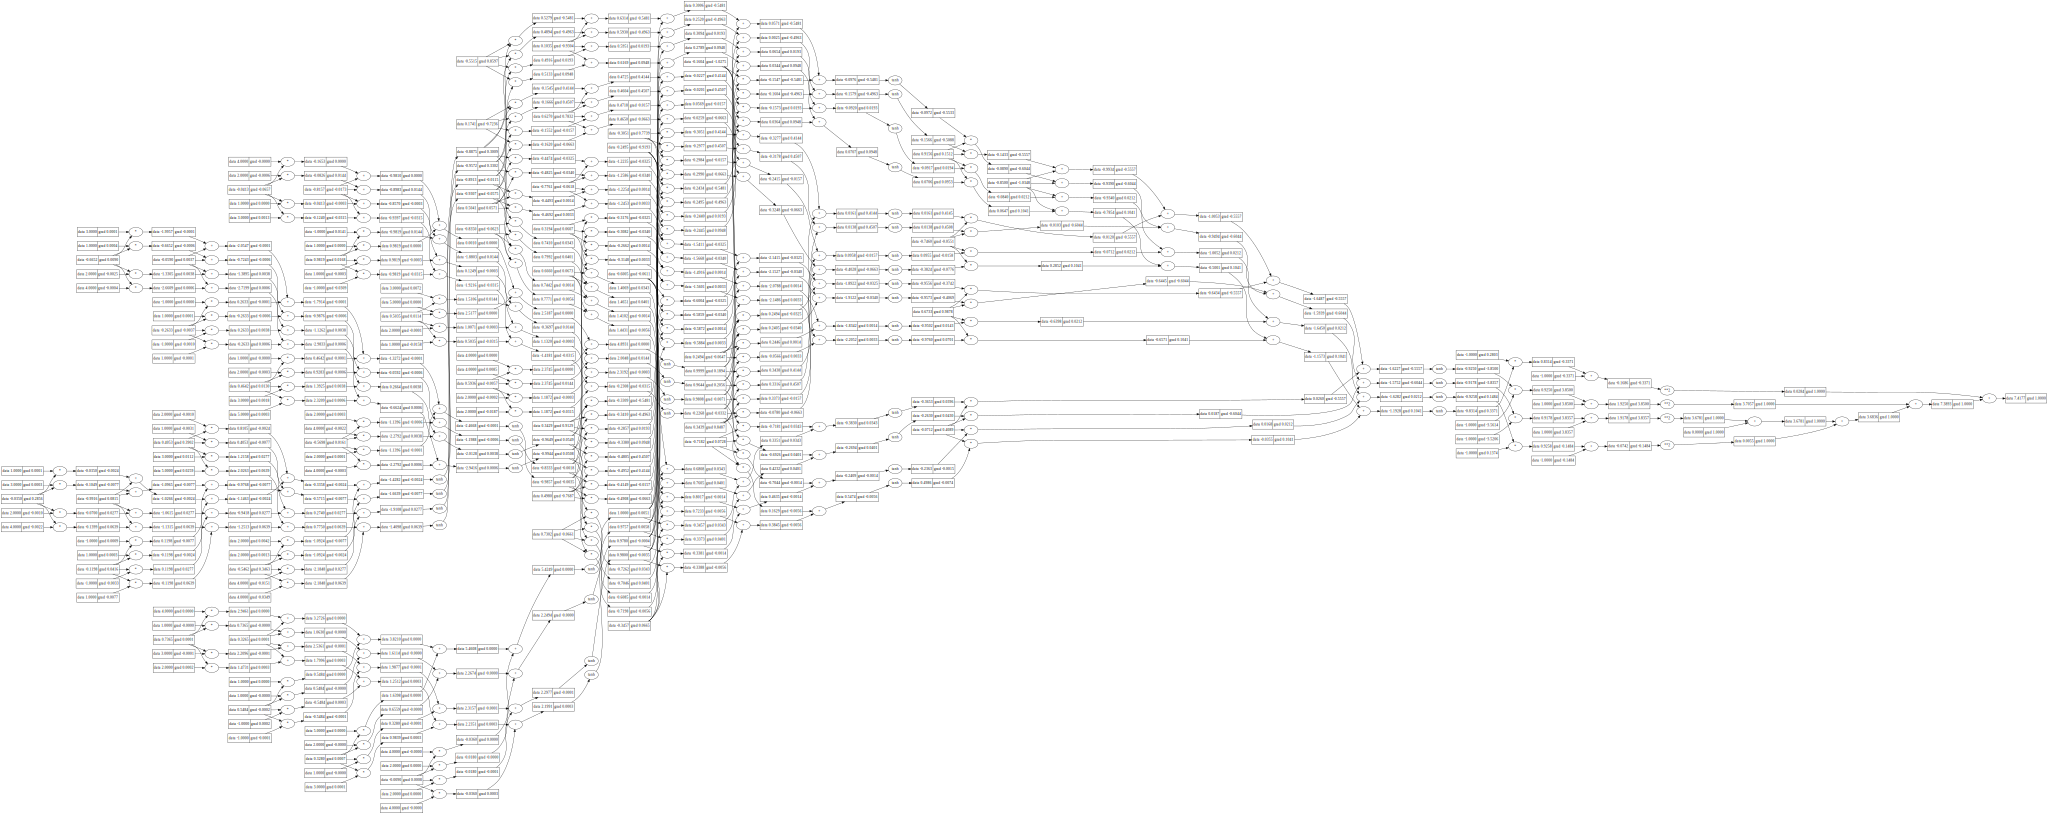

In [ ]:
draw_dot(loss)